# INFO 3402 – Class 36: Time series analysis

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Credit also goes to Jake VanderPlas's *[Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)* and Justin Markham's [DAT4](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb) notebooks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

import statsmodels.formula.api as smf
import statsmodels.api as sm

We will return to the DIA passenger activity data we first explored back in Class 13 with data cleaning.

In [2]:
dia_passengers = pd.read_csv('dia_passengers.csv',parse_dates=['date'])

dia_passengers.head()

,date,passengers
0,1995-02-01,70562.0
1,1995-03-01,2842669.0
2,1995-04-01,2422712.0
3,1995-05-01,2532545.0
4,1995-06-01,2803418.0


Visualize the data.

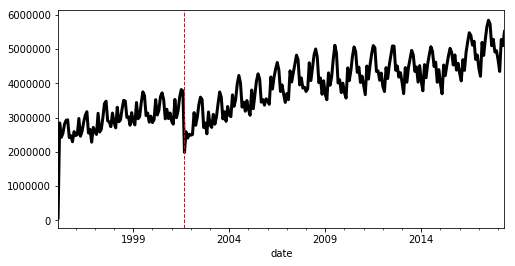

In [3]:
# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,4))

# Put the "date" column as an index, access the remaining "passengers" column, and plot on the ax defined above
dia_passengers.set_index('date')['passengers'].plot(c='k',lw=3,ax=ax)

# Make a vertical red line on September 11, 2001
ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

There is a strong annual pattern (at least, more on other signals hiding in the data below) in this data. If we wanted to erase this annual signal, we could use `.rolling(12).mean()` average the values across 12 months out together.

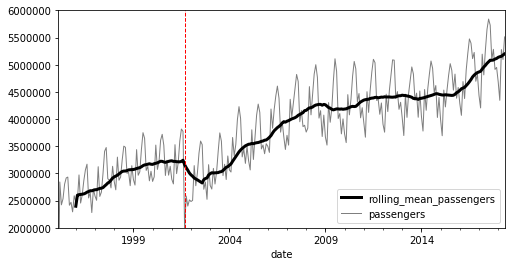

In [4]:
f,ax = plt.subplots(1,1,figsize=(8,4))
dia_passengers['rolling_mean_passengers'] = dia_passengers['passengers'].rolling(12).mean()
dia_passengers.plot(x='date',y='rolling_mean_passengers',ax=ax,lw=3,color='k')
dia_passengers.plot(x='date',y='passengers',ax=ax,lw=1,color='k',alpha=.5)
ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)
ax.set_ylim((2e6,6e6));

Using `rolling` can be helpful to smooth out data for a visualization to show underlying trends. But if our goal is to model monthly passengers, we probably want to preserve this monthly variation as a useful feature.  

Make a new column with the month and make a `catplot` of the distribution of passengers by month of the year.

In [5]:
dia_passengers['month'] = dia_passengers['date'].apply(lambda x:x.month)
dia_passengers['year'] = dia_passengers['date'].apply(lambda x:x.year)

dia_passengers.head()

,date,passengers,rolling_mean_passengers,month,year
0,1995-02-01,70562.0,NaN,2,1995
1,1995-03-01,2842669.0,NaN,3,1995
2,1995-04-01,2422712.0,NaN,4,1995
3,1995-05-01,2532545.0,NaN,5,1995
4,1995-06-01,2803418.0,NaN,6,1995


statsmodels provides a variety of tools for "decomposing" a time-series into its seasonal, trend, and residual components. We are going to explore each of these in turn through the lens of linear regression.

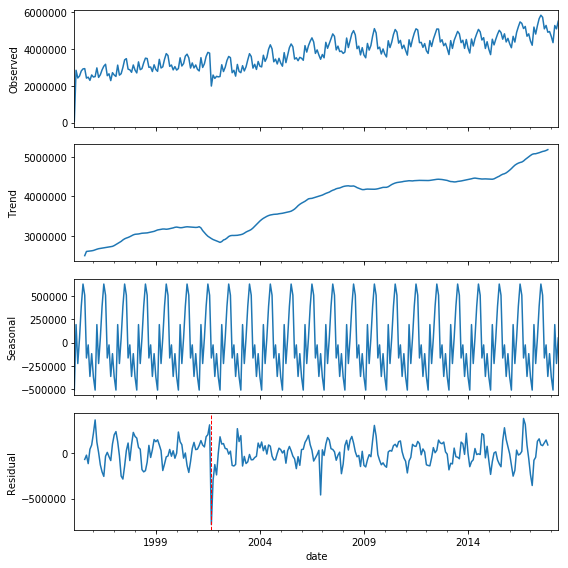

In [6]:
# This works best with a series having Timestamp/datetime objects as index
# So set the index to date and retrieve appropriate column to make a Series
decomposition = sm.tsa.seasonal_decompose(dia_passengers.set_index('date')['passengers'],model='additive')

plt.rcParams["figure.figsize"] = (8,8)
f = decomposition.plot()

f.axes[-1].axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

Building on our intuitions about regression from last week, we could fit a simple pairwise linear model. First we need to calculate a "months_since_opening" variable because the `Timestamp` objects are not the simple integers or floats that seaborn's `lmplot` or statsmodel's `ols` expects.

The operation in the numerator creates a pandas [`Timedelta`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html) object. We can divide a `Timedelta` by a unit `Timedelta` to get a simple float back. In this case, the resulting float is the number of months since the opening in January 1995.

In [7]:
dia_passengers['months_since_opening'] = (dia_passengers['date'] - pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
dia_passengers.head()

,date,passengers,rolling_mean_passengers,month,year,months_since_opening
0,1995-02-01,70562.0,NaN,2,1995,1.018501
1,1995-03-01,2842669.0,NaN,3,1995,1.938438
2,1995-04-01,2422712.0,NaN,4,1995,2.956940
3,1995-05-01,2532545.0,NaN,5,1995,3.942586
4,1995-06-01,2803418.0,NaN,6,1995,4.961087


Start with 

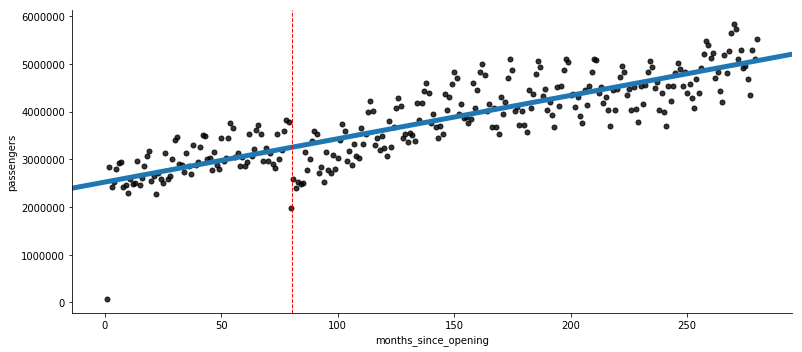

In [8]:
# Make the lmplot using seaborn
g = sb.lmplot(x='months_since_opening',y='passengers',data=dia_passengers,aspect=2.25,ci=0,
              scatter_kws={'color':'k','s':25},line_kws={'lw':5})

# Access the underlying ax object
ax = g.axes[0,0]

# Make a vertical red line on the number of months between September 11, 2001 and opening in January 1995
months_until_911 = (pd.Timestamp('2001-09-11')-pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
ax.axvline(months_until_911,color='r',ls='--',lw=1)

Fitting a linear regression to the data, interpret:

* The model performance.
* The "months_since_opening" co-efficient.
* The statistical significance of the "months_since_opening" estimate.

In [9]:
m0 = smf.ols('passengers ~ months_since_opening',data=dia_passengers).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     771.2
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           3.71e-82
Time:                        11:18:23   Log-Likelihood:                -4036.2
No. Observations:                 280   AIC:                             8076.
Df Residuals:                     278   BIC:                             8084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.522e+06    5.3e+04     47.585      0.000    2.42e+06    2.63e+06
months_since_opening  9080.2337    326.978     27.770      0.000    8436.566    9723.901
==============================================================================
Omnibus:                       34.346   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.140
Skew:                          -0.534   Prob(JB):                     3.61e-21
Kurtosis:                       5.632   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Modelling de-periodized data

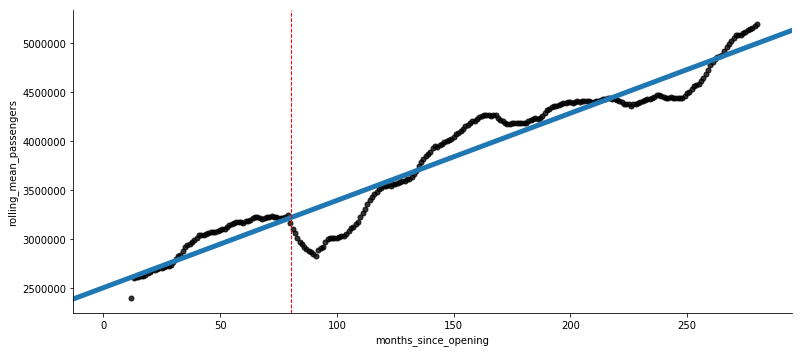

In [10]:
# Make the lmplot using seaborn
g = sb.lmplot(x='months_since_opening',y='rolling_mean_passengers',data=dia_passengers,aspect=2.25,ci=0,
              scatter_kws={'color':'k','s':25},line_kws={'lw':5})

# Access the underlying ax object
ax = g.axes[0,0]

# Make a vertical red line on the number of months between September 11, 2001 and opening in January 1995
months_until_911 = (pd.Timestamp('2001-09-11')-pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
ax.axvline(months_until_911,color='r',ls='--',lw=1)

Fit and interpret the regression model.

In [11]:
m1 = smf.ols('rolling_mean_passengers ~ months_since_opening',data=dia_passengers).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     rolling_mean_passengers   R-squared:                       0.936
Model:                                 OLS   Adj. R-squared:                  0.935
Method:                      Least Squares   F-statistic:                     3873.
Date:                     Mon, 15 Apr 2019   Prob (F-statistic):          5.89e-161
Time:                             11:25:08   Log-Likelihood:                -3639.2
No. Observations:                      269   AIC:                             7282.
Df Residuals:                          267   BIC:                             7290.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.503e+06   2.37e+04    105.762      0.000    2.46e+06    2.55e+06
months_since_opening  8907.5606    143.128     62.235      0.000    8625.757    9189.364
==============================================================================
Omnibus:                       18.847   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.360
Skew:                          -0.679   Prob(JB):                     2.30e-05
Kurtosis:                       2.752   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

But if we do not ignore these monthly changes, we can see they have an interesting pattern.

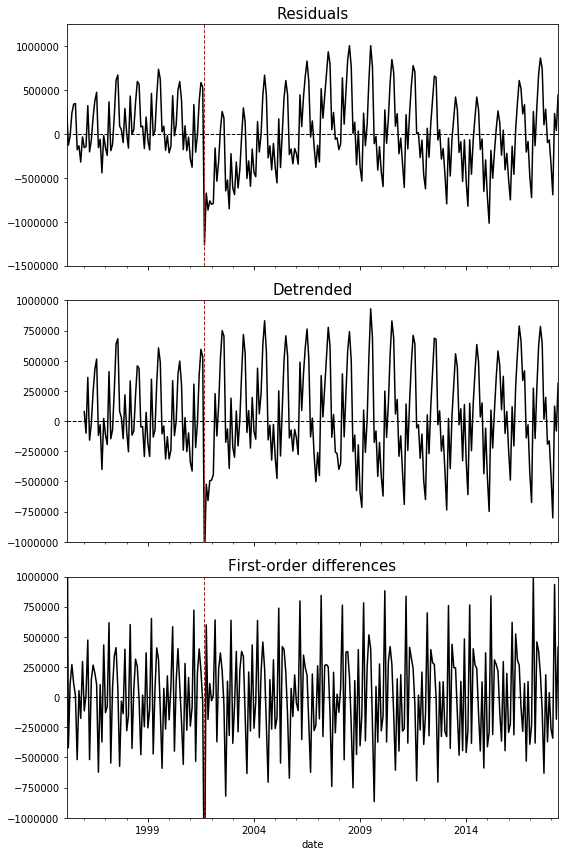

In [12]:
residuals_df = pd.DataFrame({'residuals':dia_passengers['passengers'] - m0.fittedvalues,
                             'detrended':dia_passengers['passengers'] - dia_passengers['passengers'].rolling(12).mean(),
                             'differenced':dia_passengers['passengers'].diff(),
                             'months_since_opening':dia_passengers['months_since_opening'],
                             'date':dia_passengers['date']
                            })

f,axs = plt.subplots(3,1,figsize=(8,12),sharex=True)
residuals_df.loc[1:].plot.line(x='date',y='residuals',ax=axs[0],color='k',legend=False)
residuals_df.loc[1:].plot.line(x='date',y='detrended',ax=axs[1],color='k',legend=False)
residuals_df.loc[1:].plot.line(x='date',y='differenced',ax=axs[2],color='k',legend=False)
axs[0].set_ylim((-1.5e6,1.25e6))
axs[1].set_ylim((-1e6,1e6))
axs[2].set_ylim((-1e6,1e6))

axs[0].set_title('Residuals',fontsize=15)
axs[1].set_title('Detrended',fontsize=15)
axs[2].set_title('First-order differences',fontsize=15)

axs[0].axhline(0,c='k',ls='--',lw=1)
axs[0].axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

axs[1].axhline(0,c='k',ls='--',lw=1)
axs[1].axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

axs[2].axhline(0,c='k',ls='--',lw=1)
axs[2].axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

f.tight_layout()

## Time as fixed effects
This is the underlying monthly pattern that repeats year-to-year in combination with the increasing passenger numbers.

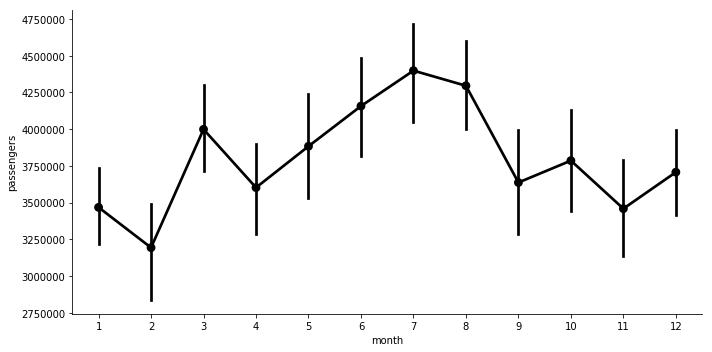

In [13]:
sb.catplot(x='month',y='passengers',data=dia_passengers,kind='point',aspect=2,color='k')

Now that we have the months in the data, we could use those as "fixed effects" in a regression model by using the repeating "month" variable as a category. This captures the same pattern as the `catplot` above.

Interpret:
* The model performance, both in absolute terms and compared to `m0` and `m1`.
* The "months_since_opening" co-efficient.
* The statistical significance of the "months_since_opening" estimate.
* The C(mont) co-efficients and their statistical significance, especially relative to the `catplot`.

In [14]:
m2 = smf.ols('passengers ~ months_since_opening + C(month)',data=dia_passengers).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     222.2
Date:                Mon, 15 Apr 2019   Prob (F-statistic):          2.71e-131
Time:                        11:32:08   Log-Likelihood:                -3886.6
No. Observations:                 280   AIC:                             7799.
Df Residuals:                     267   BIC:                             7846.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.152e+06   6.19e+04     34.747      0.000    2.03e+06    2.27e+06
C(month)[T.2]        -2.287e+05   7.72e+04     -2.963      0.003   -3.81e+05   -7.67e+04
C(month)[T.3]         5.682e+05   7.72e+04      7.362      0.000    4.16e+05     7.2e+05
C(month)[T.4]         1.621e+05   7.72e+04      2.100      0.037    1.01e+04    3.14e+05
C(month)[T.5]         4.345e+05   7.72e+04      5.629      0.000    2.82e+05    5.86e+05
C(month)[T.6]         7.534e+05    7.8e+04      9.659      0.000       6e+05    9.07e+05
C(month)[T.7]         9.857e+05    7.8e+04     12.636      0.000    8.32e+05    1.14e+06
C(month)[T.8]         8.734e+05    7.8e+04     11.198      0.000     7.2e+05    1.03e+06
C(month)[T.9]         2.056e+05    7.8e+04      2.635      0.009     5.2e+04    3.59e+05
C(month)[T.10]        3.455e+05    7.8e+04      4.430      0.000    1.92e+05    4.99e+05
C(month)[T.11]        9385.3684    7.8e+04      0.120      0.904   -1.44e+05    1.63e+05
C(month)[T.12]        2.486e+05    7.8e+04      3.187      0.002     9.5e+04    4.02e+05
months_since_opening  9142.4405    195.604     46.740      0.000    8757.319    9527.562
==============================================================================
Omnibus:                      135.916   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1177.369
Skew:                          -1.754   Prob(JB):                    2.18e-256
Kurtosis:                      12.413   Cond. No.                     2.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Another way we can visualize what this model is capturing is by hue-ing the data by year. Now we see the month-to-month patterns that "C(month)" models as well as the year-over-year increases that "months_since_opening" captures (we could have also replaced "months_since_opening" with "year" and gotten a nearly-identical model.

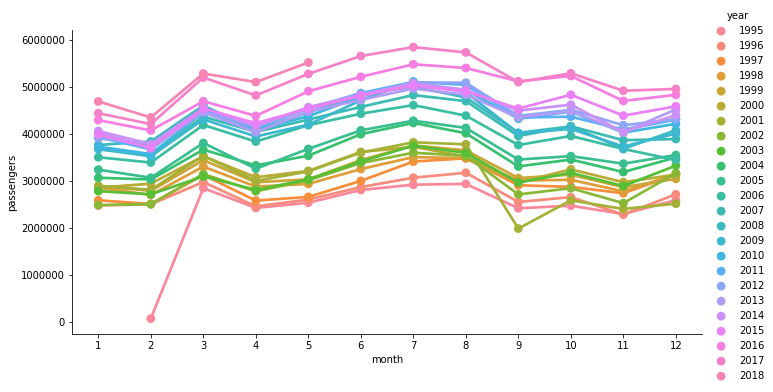

In [15]:
sb.catplot(x='month',y='passengers',hue='year',data=dia_passengers,kind='point',aspect=2)

## Predictions

Create a new DataFrame `predict_passengers` with monthly dates between Jan 1 2017 and Jan 1 2022 and give it an index that overlaps with the `dia_passengers` for the same dates. Re-compute the "months_since_opening" and "month" columns.

In [16]:
predict_passengers = pd.DataFrame({'date':pd.date_range('2017-01-01','2025-01-01',freq='M')},
                                  index=range(263,263+96))

predict_passengers['months_since_opening'] = (predict_passengers['date'] - pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
predict_passengers['month'] = predict_passengers['date'].apply(lambda x:x.month)

predict_passengers.head()

,date,months_since_opening,month
263,2017-01-31,265.007495,1
264,2017-02-28,265.927432,2
265,2017-03-31,266.945933,3
266,2017-04-30,267.931580,4
267,2017-05-31,268.950081,5


Use the `.predict()` method on the models we trained above with data over the range in `predict_passengers`. Plot the data to compare the observations with the predictions and the forecasts.

Text(0, 0.5, 'Passengers')

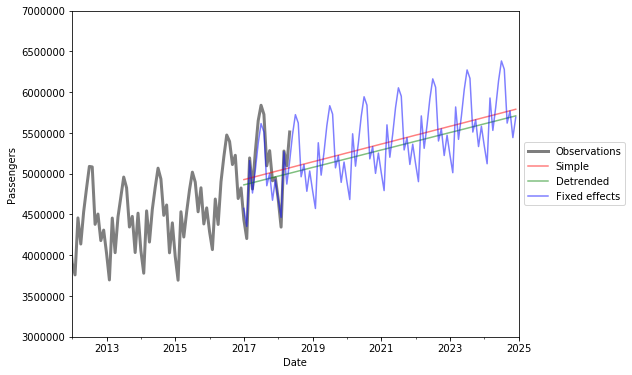

In [17]:
predict_passengers['m0'] = m0.predict({'months_since_opening':predict_passengers['months_since_opening']})
predict_passengers['m1'] = m1.predict({'months_since_opening':predict_passengers['months_since_opening']})
predict_passengers['m2'] = m2.predict({'months_since_opening':predict_passengers['months_since_opening'],
                                       'month':predict_passengers['month']})

f,ax = plt.subplots(1,1,figsize=(8,6))

dia_passengers.plot(x='date',y='passengers',ax=ax,c='k',label='Observations',lw=3,alpha=.5)
predict_passengers.plot(x='date',y='m0',ax=ax,c='r',label='Simple',alpha=.5)
predict_passengers.plot(x='date',y='m1',ax=ax,c='g',label='Detrended',alpha=.5)
predict_passengers.plot(x='date',y='m2',ax=ax,c='b',label='Fixed effects',alpha=.5)
ax.set_xlim((pd.Timestamp('2012-01-01'),pd.Timestamp('2025-01-01')))
ax.set_ylim(3e6,7e6)
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

## Advanced: Periodograms and power spectra
In signal processing, you can use a fast Fourier transform to generate a power [spectral density](https://en.wikipedia.org/wiki/Spectral_density) plot to find cyclical patterns in the data. The math behind this technique is beyond the scope of the class, but it's a powerful  technique for discovering different cyclical patterns hiding within a time series.

In [18]:
from scipy import signal
x, y = signal.periodogram(residuals_df['residuals'])
signal_df = pd.DataFrame({'x':x,'y':y})
signal_df.sort_values('y',ascending=False).head(7)

,x,y
23,0.082143,1.791966e+13
2,0.007143,5.416282e+12
117,0.417857,4.690669e+12
70,0.250000,3.961251e+12
24,0.085714,2.833030e+12
47,0.167857,1.777504e+12
4,0.014286,1.345511e+12


Visualize the power spectral density to find other cyclical patterns hiding in the time series.

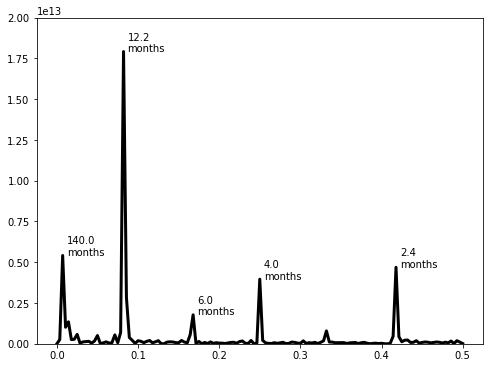

In [19]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x,y,lw=3,c='k')
# ax.set_xscale('log')
ax.set_ylim((0,2e13))

# Select the strongest, non-adjacent signal indices from the sorted signal_df above
for _ix in [23,2,117,70,47]:
    ax.text(signal_df.loc[_ix,'x']+.005,signal_df.loc[_ix,'y'],"{0:.1f}\nmonths".format(1/signal_df.loc[_ix,'x']))
    

We can simulate what a time series with these different frequencies looks like, adding each frequency to see how the time series changes. (The amplitudes and lags are not right, but this conveys the general ideal of how overlapping frequencies can be present in a signal.)

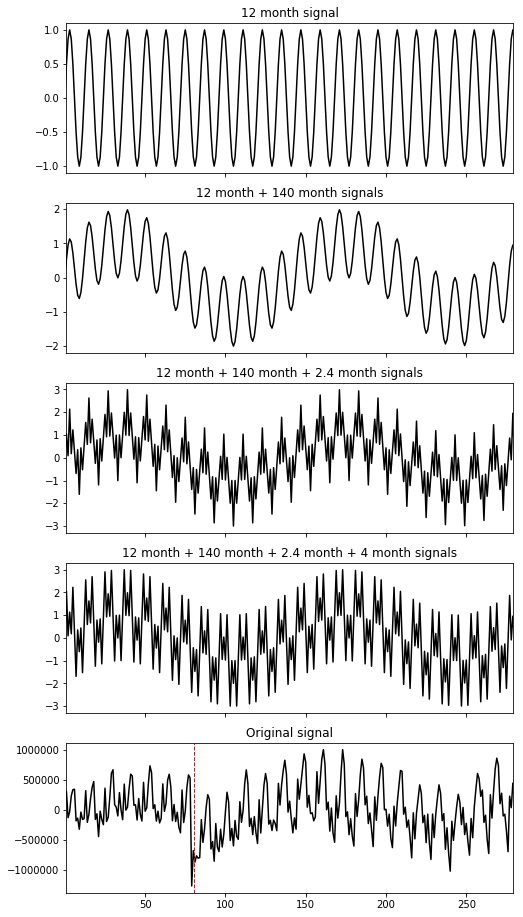

In [20]:
f,axs = plt.subplots(5,1,figsize=(8,16),sharex=True)
t = np.linspace(0,280,281)

# Start with the strongest signal
y0 = np.sin(1/12*2*np.pi*t)

# Add second-strongest signal
y1 = np.sin(1/12*2*np.pi*t) + np.sin(1/140*2*np.pi*t)

# Add third-strongest signal
y2 = np.sin(1/12*2*np.pi*t) + np.sin(1/140*2*np.pi*t) + np.sin(1/2.4*2*np.pi*t)

# Add fourth-strongest signal
y3 = np.sin(1/12*2*np.pi*t) + np.sin(1/140*2*np.pi*t) + np.sin(1/2.4*2*np.pi*t) + np.sin(1/4*2*np.pi*t)

axs[0].plot(t,y0,color='k')
axs[1].plot(t,y1,color='k')
axs[2].plot(t,y2,color='k')
axs[3].plot(t,y3,color='k')
residuals_df.loc[1:,'residuals'].plot.line(x='months_since_opening',y='residuals',ax=axs[4],color='k')

axs[0].set_title('12 month signal')
axs[1].set_title('12 month + 140 month signals')
axs[2].set_title('12 month + 140 month + 2.4 month signals')
axs[3].set_title('12 month + 140 month + 2.4 month + 4 month signals')
axs[4].set_title('Original signal')

axs[4].axvline(months_until_911,color='r',ls='--',lw=1)

## Exercise

Explore the temporal features of the Global Temperature data from the [Berkeley Earth Surface Temperature](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data#GlobalTemperatures.csv) data.

Start by reading in the data.

In [21]:
temp_df = pd.read_csv('global_temperature.csv',parse_dates=['dt'])
temp_df.columns = ['date','avg_temp','avg_temp_error','max_temp','max_temp_error','min_temp','min_temp_error','avg_all_temp','avg_all_temp_error']
temp_df.head()

,date,avg_temp,avg_temp_error,max_temp,max_temp_error,min_temp,min_temp_error,avg_all_temp,avg_all_temp_error
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


Use `season_decompose` from statsmodels to visualize the trend, seasonal, and residual components of the time series.

Extract the month from "date" and add as a new column.

Create a "months_since_1750" variable using `Timestamp` and `Timedelta` (as I did above).

Plot the raw data for "avg_temp" against "date".

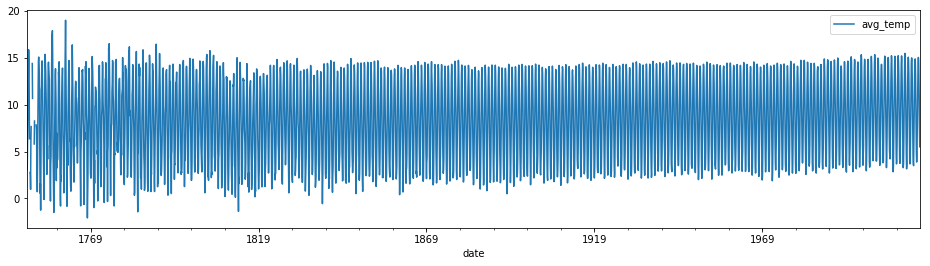

In [23]:
temp_df.plot(x='date',y='avg_temp',figsize=(16,4))

Make a rolling average of the temperatures, selecting an appropriate frequency. Visualize this to explore if there is an underlying trend.

Make a point plot using seaborn with months on the x-axis and "avg_temp" on the y-axis. Which is the warmest month of the year on average?

Fit a simple linear regression of "avg_temp" against "months_since_1750". Interpret the coefficients, significance, and model performance.